In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels as stats
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_excel("Downloads/Final_RA_data.xlsx")

### Estimating Growth in Profit with and without Imputation. So I have created the following two DataFrames.
#### df -> dataframe with all missing values removed
#### df_imp ->dataframe with missing values imputed

### Creating df by deleting all rows with missing values

In [3]:
df=data[['Companies','sgna','fyear','current_assets','age', 'ppe', 'emp', 'operating_expenses','liabilities', 'book_value','gross_profit']]
print("Original Shape of Data:", df.shape)
df.dropna(inplace=True)
print("Shape of Data after removing Missing values:", df.shape)

Original Shape of Data: (3158, 11)
Shape of Data after removing Missing values: (1328, 11)


C:\Users\nisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Creating df_imp by imputing missing values using the following technique-
#### Values for each colum are Linearly interpolating  at Company level
#### Some missing values still remain because linear interpolation does not work when entire column is NaN. So, the remaining missing values are replaced with the Column Mean*. 

#### NOTE- The Column Mean is calculated taking the entire column into account and not at Company level.

In [4]:
df_imp = pd.DataFrame()
df_imp = data[['Companies','sgna','fyear','current_assets','age', 'ppe', 'emp', 'operating_expenses','liabilities', 'book_value','gross_profit']]
print("Missing values in each column")
print(df_imp.isnull().sum())


df_imp = df_imp.groupby("Companies").transform(lambda x: x.interpolate(limit_direction='both'))
df_imp['Companies'] =  data['Companies']
print("--------------------------------------------------")
print("Missing values left out after Linear Interpolation")
print(df_imp.isnull().sum())

Missing values in each column
Companies                0
sgna                  1011
fyear                    0
current_assets         305
age                      1
ppe                    835
emp                   1153
operating_expenses     369
liabilities            656
book_value            1022
gross_profit           463
dtype: int64
--------------------------------------------------
Missing values left out after Linear Interpolation
sgna                  584
fyear                   0
current_assets         73
age                     0
ppe                   638
emp                   782
operating_expenses    207
liabilities           570
book_value            874
gross_profit          297
Companies               0
dtype: int64


#### Replacing them with Column Mean

In [5]:
df_imp['liabilities'] = df_imp['liabilities'].transform(lambda x: x.fillna(x.mean()))
df_imp['current_assets'] = df_imp['current_assets'].transform(lambda x: x.fillna(x.mean()))
df_imp['ppe'] = df_imp['ppe'].transform(lambda x: x.fillna(x.mean()))
df_imp['operating_expenses'] = df_imp['operating_expenses'].transform(lambda x: x.fillna(x.mean()))
df_imp['emp'] = df_imp['emp'].transform(lambda x: x.fillna(x.mean()))
df_imp['book_value'] = df_imp['book_value'].transform(lambda x: x.fillna(x.mean()))
df_imp['gross_profit'] = df_imp['gross_profit'].transform(lambda x: x.fillna(x.mean()))
df_imp['sgna'] = df_imp['sgna'].transform(lambda x: x.fillna(x.mean()))

In [6]:
print(df_imp.isnull().sum())

sgna                  0
fyear                 0
current_assets        0
age                   0
ppe                   0
emp                   0
operating_expenses    0
liabilities           0
book_value            0
gross_profit          0
Companies             0
dtype: int64


### Variable Creation

##### Create a quadratic term for SGNA (SQ_SGNA)

In [7]:
df['SQ_SGNA'] = (df['sgna'])**2

C:\Users\nisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
df_imp['SQ_SGNA'] = (df_imp['sgna'])**2

### Find the lag of SGNA at the company and fyear level
Selection of optimal lag at Company and fyear level -

I looked at the acf plots for each company and fyear level and found that lags 1 and 2 have the significant correlation with the presnt sgna as shown below-

In order to to get the optimal lag for every company, I have fit an OLS model to predict sgna from it's lag. I have compared the Information Criterion - AIC for lag 1, 2 and 3 and chosen the lag with the lowest AIC as the optimal lag

#### Function to find the optimal lag for every Company at fyear level

In [9]:
import statsmodels.api as sm
aic_dict = {}
df_lag=pd.DataFrame()
def get_optimal_lag(company_name):
    df_lag['X'] = df[df['Companies']==company_name].sgna
    df_lag['y'] = df[df['Companies']==company_name].sgna.shift(1)
    df_lag['X'].fillna(0,inplace=True)
    df_lag['y'].fillna(0,inplace=True)
    
    X=df_lag['X'].values.reshape(-1,1)
    Y=df_lag['y'].values.reshape(-1,1)
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    aic_dict['lag1'] = model.aic
    
    df_lag['X'] = df[df['Companies']==company_name].sgna
    df_lag['y'] = df[df['Companies']==company_name].sgna.shift(2)
    df_lag['X'].fillna(0,inplace=True)
    df_lag['y'].fillna(0,inplace=True)
    
    X=df_lag['X'].values.reshape(-1,1)
    Y=df_lag['y'].values.reshape(-1,1)
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    aic_dict['lag2'] = model.aic
    
    df_lag['X'] = df[df['Companies']==company_name].sgna
    df_lag['y'] = df[df['Companies']==company_name].sgna.shift(3)
    df_lag['X'].fillna(0,inplace=True)
    df_lag['y'].fillna(0,inplace=True)
    
    X=df_lag['X'].values.reshape(-1,1)
    Y=df_lag['y'].values.reshape(-1,1)
    X=sm.add_constant(X)
    model = sm.OLS(Y,X).fit()
    aic_dict['lag3'] = model.aic  
    return min(aic_dict, key=aic_dict.get)

#### Dictionary to store the Company and its corresponding optimal lag - optimal_lag_dict

In [10]:
optimal_lag_dict = {}
for i in set(df['Companies']):
    #optimal_lag_list.append(get_optimal_lag(i))
    optimal_lag_dict[i] = get_optimal_lag(i)    

C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [11]:
optimal_lag_dict = {}
for i in set(df_imp['Companies']):
    optimal_lag_dict[i] = get_optimal_lag(i)

#### Setting lag for every company using the optimal_lag_dict

In [12]:
for i in set(df['Companies']):
    if(optimal_lag_dict[i]=='lag1'):
        df.loc[df.Companies==i,'lag_sgna']=df[df.Companies==i].sgna.shift(1)
    if(optimal_lag_dict[i]=='lag2'):
        df.loc[df.Companies==i,'lag_sgna']=df[df.Companies==i].sgna.shift(2)
    if(optimal_lag_dict[i]=='lag3'):
        df.loc[df.Companies==i,'lag_sgna']=df[df.Companies==i].sgna.shift(3)   

C:\Users\nisha\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\nisha\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
for i in set(df_imp['Companies']):
    if(optimal_lag_dict[i]=='lag1'):
        df_imp.loc[df_imp.Companies==i,'lag_sgna']=df_imp[df_imp.Companies==i].sgna.shift(1)
    if(optimal_lag_dict[i]=='lag2'):
        df_imp.loc[df_imp.Companies==i,'lag_sgna']=df_imp[df_imp.Companies==i].sgna.shift(2)
    if(optimal_lag_dict[i]=='lag3'):
        df_imp.loc[df_imp.Companies==i,'lag_sgna']=df_imp[df_imp.Companies==i].sgna.shift(3)   

#### Creating SGNA_MKT varables for by finding the moving average of SGNA for each firm for 3 years

In [14]:
for i in set(df['Companies']):
    df.loc[df.Companies==i,'sgna_mkt']=df[df.Companies==i].sgna.rolling(window=3).mean()

In [15]:
for i in set(df_imp['Companies']):
    df_imp.loc[df_imp.Companies==i,'sgna_mkt']=df_imp[df_imp.Companies==i].sgna.rolling(window=3).mean()

### Calculating 'growth_in_profit'

In [16]:
for i in set(df['Companies']):
    df.loc[df.Companies==i,'lag_gross_profit']=df[df.Companies==i].sgna.shift(1)
for comp in set(df.Companies):
    df.loc[df.Companies == comp, 'growth_in_profit'] = (df['gross_profit'] - df['lag_gross_profit'])/(df['lag_gross_profit'])

In [17]:
df['growth_in_profit'].isnull().sum()

82

In [18]:
# Deleting rest of the missing values
df.isnull().sum()

df.dropna(inplace=True)

C:\Users\nisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


#### Growth in Profit for df_imp

In [19]:
for i in set(df_imp['Companies']):
    df_imp.loc[df_imp.Companies==i,'lag_gross_profit']=df_imp[df_imp.Companies==i].sgna.shift(1)
for comp in set(df_imp.Companies):
    df_imp.loc[df_imp.Companies == comp, 'growth_in_profit'] = (df_imp['gross_profit'] - df_imp['lag_gross_profit'])/(df_imp['lag_gross_profit'])

In [20]:
df_imp['growth_in_profit'].isnull().sum()

262

In [21]:
for comp in set(df_imp.Companies):
    df_imp.loc[df_imp.Companies == comp, 'growth_in_profit'] = df_imp['growth_in_profit'].transform(lambda x: x.fillna(x.mean()))

df_imp['growth_in_profit'].fillna(0, inplace=True)
df_imp.loc[df_imp['growth_in_profit'] == float("-inf"), 'growth_in_profit'] = 0
df_imp.loc[df_imp['growth_in_profit'] == float("inf"), 'growth_in_profit'] = 0

In [22]:
df_imp['growth_in_profit'].isnull().sum()

0

In [23]:
df_imp.isnull().sum()

sgna                    0
fyear                   0
current_assets          0
age                     0
ppe                     0
emp                     0
operating_expenses      0
liabilities             0
book_value              0
gross_profit            0
Companies               0
SQ_SGNA                 0
lag_sgna              239
sgna_mkt              474
lag_gross_profit      238
growth_in_profit        0
dtype: int64

#### Removing rows with missing lag_sgna, sgna_mkt,lag_gross_profit

In [24]:
df_imp.dropna(inplace=True)

### Functions for all Training Models to be used in our analysis

#### Function to draw Scatter plot

In [25]:
def scatter_plot(x,y):
    colors = (0,0,0)
    area = np.pi*3
    plt.scatter(x = x, y = y, s=area, c=colors, alpha=0.5)
    plt.title('Scatter plot')
    plt.show()

#### Function to print model metrics MAE, MSE, RMSE and R-squared

In [26]:
from sklearn.metrics import mean_squared_error, r2_score
def printMetrics(y_actual,y_predicted):
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_actual, y_predicted))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_actual, y_predicted))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_actual, y_predicted)))
    print('R-squared:',metrics.r2_score(y_actual, y_predicted))

#### Functions for Linear, Ridge, ElasticNet and Lasso Regression

In [27]:
#Linear Regression
from sklearn.linear_model import LinearRegression
def LinearReg(iv,dv):
    lm = LinearRegression()
    lm.fit(iv,dv)
    return lm

#Lasso Regression
from sklearn.linear_model import Lasso
def LassoReg(iv,dv):
    lasso = Lasso()
    lasso.fit(iv,dv)
    return lasso

#Ridge Regression
from sklearn.linear_model import Ridge
def RidgeReg(iv,dv):
    ridge = Ridge()
    ridge.fit(iv,dv)
    return ridge
        
#ElasticNet Regression
from sklearn.linear_model import ElasticNet
def ElasticNetReg(iv,dv):
    elastic = ElasticNet()
    elastic.fit(iv,dv)
    return elastic

#### Functions for Support Vector Regression

In [28]:
#Support Vector Regression with Kernel RBF
from sklearn.svm import SVR
def SVR_RBF(iv,dv):
    svr = SVR(kernel='rbf')
    svr.fit(iv,dv)
    return svr

#Linear Support Vector Regression
from sklearn.svm import LinearSVR
def SVR_Linear(iv,dv):
    lsvr = LinearSVR(random_state=0, tol=1e-5)
    lsvr.fit(iv,dv)
    return lsvr

#### Function for XGBoost with different Tuning parameters 

In [29]:
import xgboost as xgb
def XGBoostReg(iv,dv,max_depth,objective,n_estimators,learning_rate):
    data_dmatrix = xgb.DMatrix(data=iv,label=dv)
    xg_reg = xgb.XGBRegressor(objective =objective, colsample_bytree = 0.3, learning_rate = learning_rate,
                    max_depth = max_depth, alpha = 10, n_estimators = n_estimators)
    xg_reg.fit(iv,dv)
    return xg_reg

#### Function for AdaBoost with different Tuning parameters

In [30]:
from sklearn.ensemble import AdaBoostRegressor
def AdaBoost(iv,dv,n_estimators,learning_rate):
    ada = AdaBoostRegressor(n_estimators=n_estimators,
                             learning_rate=learning_rate)
    ada.fit(iv,dv)
    return ada

#### Function for Decision Tree Regression with different Tuning parameters

In [31]:
from sklearn.tree import DecisionTreeRegressor
def DecisionTreeReg(iv,dv,max_depth):
    dec = DecisionTreeRegressor(max_depth=max_depth)
    dec.fit(iv,dv)
    return dec

#### Orthogonal Matching Pursuit Function

In [32]:
from sklearn.linear_model import OrthogonalMatchingPursuit

def OrthogonalMatchReg(iv,dv):
    orth = OrthogonalMatchingPursuit().fit(iv, dv)
    return orth

#### Bayesian Ridge Regression Function

In [33]:
from sklearn import linear_model
def BayesianRidgeReg(iv,dv):
    bridge = linear_model.BayesianRidge().fit(iv, dv)
    return bridge

#### Function for Robust Linear Model Estimation using RANSAC

In [34]:
from sklearn import linear_model
def RansacReg(iv,dv):
    ransac = linear_model.RANSACRegressor().fit(iv,dv)
    return ransac

#### RandomForest Regression Function

In [35]:
from sklearn.ensemble import RandomForestRegressor
def RandomForestReg(iv,dv,n_estimators,random_state):
    rf = RandomForestRegressor(n_estimators = n_estimators, random_state = random_state)
    rf.fit(iv,dv)
    return rf

#### Gradient Boosting Regression Function

In [36]:
from sklearn import ensemble
def GradientBoostReg(iv,dv,n_estimators,max_depth,learning_rate,criterion):
    gbreg = ensemble.GradientBoostingRegressor(n_estimators=n_estimators,max_depth=max_depth,
                                               learning_rate=learning_rate,criterion=criterion)
    gbreg.fit(iv,dv)
    return gbreg

#### Function for forward-backward Feature selection based on p-value from statsmodels.api.OLS

In [37]:
import statsmodels.formula.api as smf

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05,
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

#### Function to predict Growth_In_Profit using a Specified Model

In [38]:
def RegPredict(lm,iv,dv):
    y_pred= lm.predict(iv)
    printMetrics(dv,y_pred)
    return y_pred

#### Function to plot Feature Importances 

In [39]:
def plot_feature_imp(lm,index):
    a=lm.coef_.tolist()
    flat_coeff_list = [val for sublist in a for val in sublist]
    feature_imp = pd.Series(flat_coeff_list, index=index).sort_values(ascending=True)
    feature_imp.plot(kind='barh', title='Feature Importance')
    plt.show()

In [40]:
# Feature Importance function fro ElasticNet
def plot_feature_imp_EN(lm,index):
    feature_imp = pd.Series(lm.coef_, index=index).sort_values(ascending=True)
    feature_imp.plot(kind='barh', title='Feature Importance')
    plt.show()

### a.	Estimate a regression model with SGNA as dependent variable and lag_sgna and sgna_mkt as independent variables. Store the residual of the model NAMED AS “R1”

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


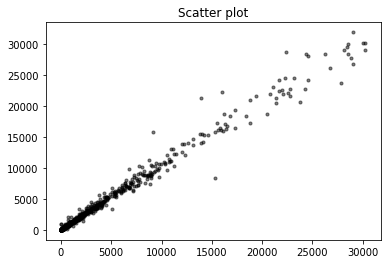

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


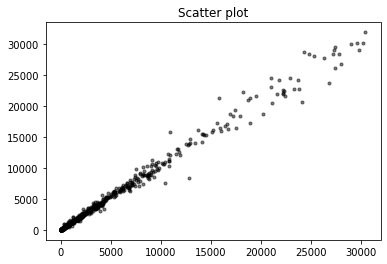

Linear Regression Metrics
Mean Absolute Error: 207.41381106368226
Mean Squared Error: 235335.23416669117
Root Mean Squared Error: 485.11363015966805
R-squared: 0.9915138646367065


C:\Users\nisha\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [41]:
x1 = df[['lag_sgna', 'sgna_mkt']]
y1 = df['sgna']
scatter_plot(x = x1['lag_sgna'], y = y1)
scatter_plot(x = x1['sgna_mkt'], y = y1)
x1.fillna(0,inplace=True)
print("Linear Regression Metrics")
rd=LinearReg(x1,y1)
pred=RegPredict(rd,x1,y1)

Distribution of residuals


C:\Users\nisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


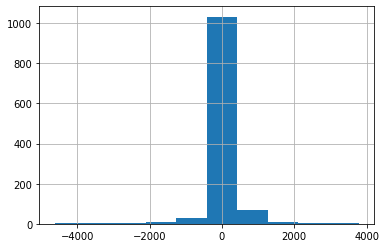

In [42]:
df['R1'] = df['sgna'] - pred
print("Distribution of residuals")
df['R1'].hist()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


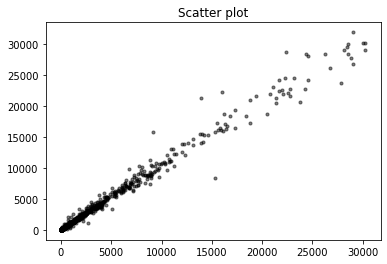

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


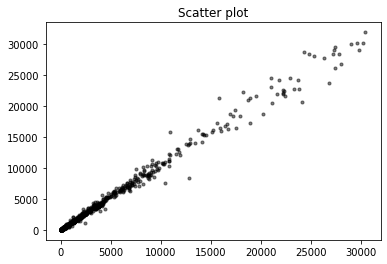

Linear Regression Metrics
Mean Absolute Error: 109.09551078396623
Mean Squared Error: 106200.84963594824
Root Mean Squared Error: 325.8847183222132
R-squared: 0.9922404292712665


C:\Users\nisha\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [43]:
x1 = df_imp[['lag_sgna', 'sgna_mkt']]
y1 = df_imp['sgna']
scatter_plot(x = x1['lag_sgna'], y = y1)
scatter_plot(x = x1['sgna_mkt'], y = y1)
x1.fillna(0,inplace=True)
print("Linear Regression Metrics")
rd=LinearReg(x1,y1)
pred=RegPredict(rd,x1,y1)

Distribution of residuals


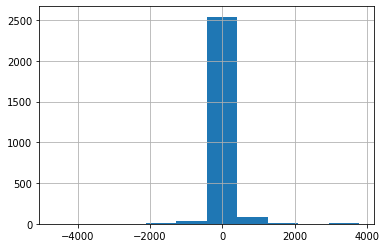

In [44]:
df_imp['R1'] = df_imp['sgna'] - pred
print("Distribution of residuals")
df_imp['R1'].hist()

### Model 2: DV=Growth in Profit, IV= SGNA and SQ_SGNA; CONTROL= current assets, age, ppe, emp, operating expenses, liabilities, book value, r1

#### Defining Variables

In [45]:
DV = ['growth_in_profit']
IV = ['sgna', 'SQ_SGNA']
CV = ['current_assets','age', 'ppe', 'emp', 'operating_expenses','liabilities', 'book_value','R1']

#### Splitting data into Train and Test sets

In [46]:
X = df[IV + CV]
y = df[DV].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [47]:
X_imp = df_imp[IV + CV]
y_imp = df_imp[DV].values.reshape(-1,1)

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp, y_imp, test_size=0.2, random_state=0)

#### Checking Correlation

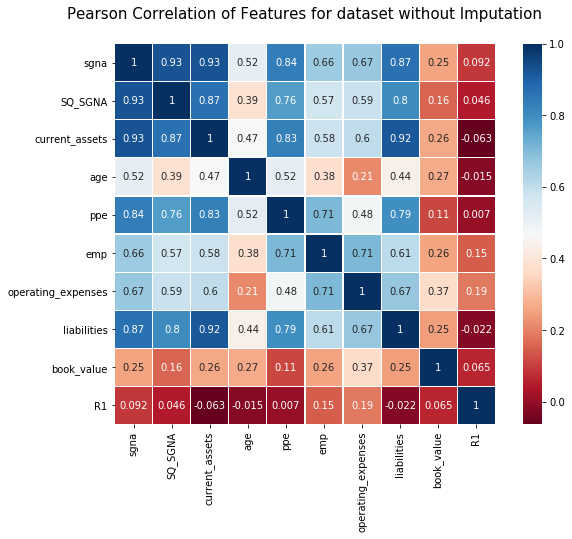

In [48]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10,7))
plt.title('Pearson Correlation of Features for dataset without Imputation', y=1.05, size=15)
sns.heatmap(X.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
# Note that the categorical features have been neglected in the
# correlation matrix.

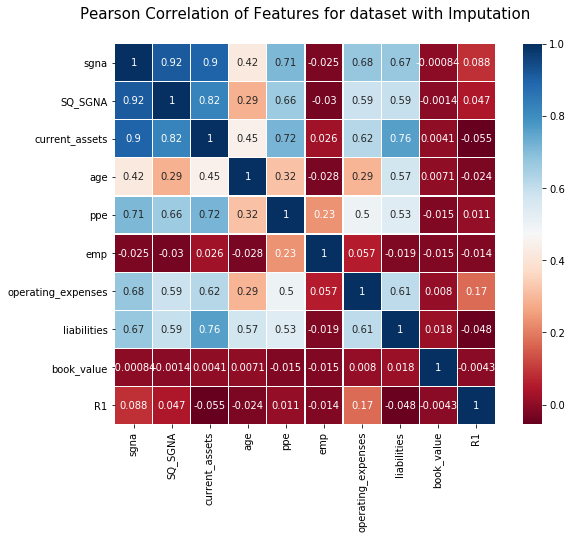

In [49]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10,7))
plt.title('Pearson Correlation of Features for dataset with Imputation', y=1.05, size=15)
sns.heatmap(X_imp.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
# Note that the categorical features have been neglected in the
# correlation matrix.

### Linear Regression

Linear Regression Results - without Imputation
Mean Absolute Error: 1.3852064969054572
Mean Squared Error: 51.52200467650966
Root Mean Squared Error: 7.17788302192991
R-squared: 0.11016842333958798


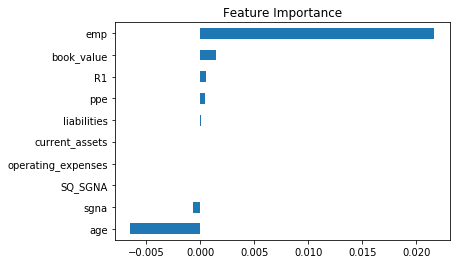

In [50]:
print("Linear Regression Results - without Imputation")
lr=LinearReg(X_train,y_train)
pred=RegPredict(lr,X_test,y_test)

#Plotting Feature Importances 
feature_list = list(X.columns)
plot_feature_imp(lr,index=feature_list)

Linear Regression Results - with Imputation
Mean Absolute Error: 14.686772088146535
Mean Squared Error: 12746.574597794975
Root Mean Squared Error: 112.90072895156601
R-squared: 0.004371600587501523


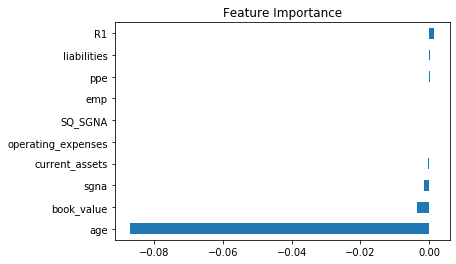

In [51]:
print("Linear Regression Results - with Imputation")
lr=LinearReg(X_train_imp,y_train_imp)
pred=RegPredict(lr,X_test_imp,y_test_imp)

#Plotting Feature Importances 
feature_list = list(X_imp.columns)
plot_feature_imp(lr,index=feature_list)

### Lasso Regression

Lasso Regression Metrics - without Imputation
Mean Absolute Error: 1.3787595055556459
Mean Squared Error: 51.62532251724244
Root Mean Squared Error: 7.185076375185057
R-squared: 0.10838403087090143


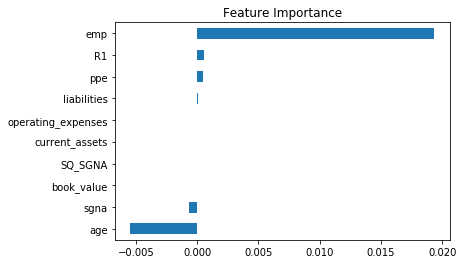

In [52]:
print("Lasso Regression Metrics - without Imputation")
las=LassoReg(X_train,y_train)
pred=RegPredict(las,X_test,y_test)

#Plotting Feature Importances 
feature_list = list(X.columns)
plot_feature_imp_EN(las,index=feature_list)

Lasso Regression Results - with Imputation
Mean Absolute Error: 14.67357817111723
Mean Squared Error: 12746.806525752789
Root Mean Squared Error: 112.90175607913629
R-squared: 0.0043534848137580795


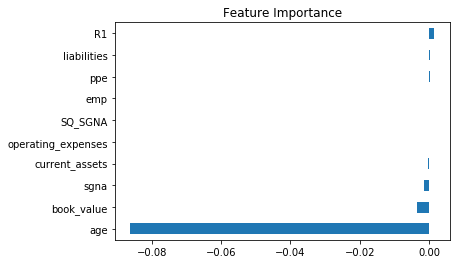

In [53]:
print("Lasso Regression Results - with Imputation")
las=LassoReg(X_train_imp,y_train_imp)
pred=RegPredict(las,X_test_imp,y_test_imp)

#Plotting Feature Importances 
feature_list = list(X_imp.columns)
plot_feature_imp_EN(las,index=feature_list)

### Ridge Regression

Ridge Regression Metrics -- Without Imputation
Mean Absolute Error: 1.3852063310828227
Mean Squared Error: 51.522006653022416
Root Mean Squared Error: 7.177883159610667
R-squared: 0.11016838920342664


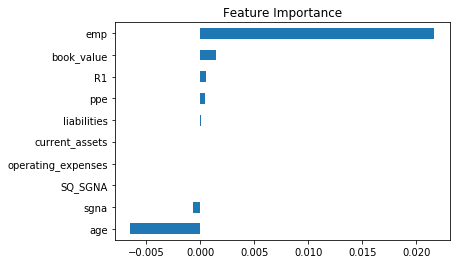

In [54]:
print("Ridge Regression Metrics -- Without Imputation")
rd=RidgeReg(X_train,y_train)
pred=RegPredict(rd,X_test,y_test)

#Plotting Feature Importances 
feature_list = list(X.columns)
plot_feature_imp(rd,index=feature_list)

Ridge Regression Metrics -- With Imputation
Mean Absolute Error: 14.686771558192042
Mean Squared Error: 12746.574606480322
Root Mean Squared Error: 112.90072899003054
R-squared: 0.0043715999090935265


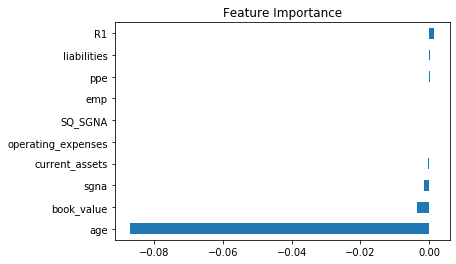

In [55]:
print("Ridge Regression Metrics -- With Imputation")
rd=RidgeReg(X_train_imp,y_train_imp)
pred=RegPredict(rd,X_test_imp,y_test_imp)

#Plotting Feature Importances 
feature_list = list(X_imp.columns)
plot_feature_imp(rd,index=feature_list)

### ElasticNet Regression

ElasticNet Regression Results - without Imputation
Mean Absolute Error: 1.3812840964142876
Mean Squared Error: 51.576131613134024
Root Mean Squared Error: 7.1816524291512485
R-squared: 0.10923360223434064


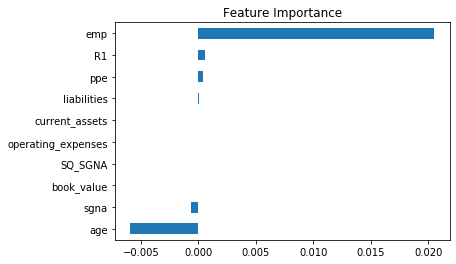

In [56]:
print("ElasticNet Regression Results - without Imputation")
en=ElasticNetReg(X_train,y_train)
pred=RegPredict(en,X_test,y_test)

#Plotting Feature Importances after adding CV individually
feature_list = list(X.columns)
plot_feature_imp_EN(en,index=feature_list)

Lasso Regression Results - with Imputation
Mean Absolute Error: 14.679563618570066
Mean Squared Error: 12746.69965085732
Root Mean Squared Error: 112.90128276887432
R-squared: 0.004361832756987649


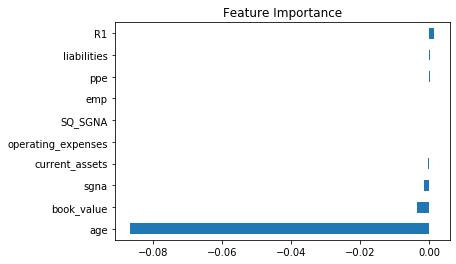

In [57]:
print("Lasso Regression Results - with Imputation")
en=ElasticNetReg(X_train_imp,y_train_imp)
pred=RegPredict(en,X_test_imp,y_test_imp)

#Plotting Feature Importances 
feature_list = list(X_imp.columns)
plot_feature_imp_EN(en,index=feature_list)

### Support Vector Regression

In [58]:
print("Support Vector with RBF Kernel Regression Results - Without Imputation")
svr=SVR_RBF(X_train,y_train)
pred=RegPredict(svr,X_test,y_test)

Support Vector with RBF Kernel Regression Results - Without Imputation
Mean Absolute Error: 1.2341401380141708
Mean Squared Error: 58.34546894243914
Root Mean Squared Error: 7.638420579048992
R-squared: -0.007678970296597143


C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [59]:
print("Support Vector with RBF Kernel Regression Results - With Imputation")
svr=SVR_RBF(X_train_imp,y_train_imp)
pred=RegPredict(svr,X_test_imp,y_test_imp)

Support Vector with RBF Kernel Regression Results - With Imputation


C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean Absolute Error: 10.243880800317847
Mean Squared Error: 12877.983098989607
Root Mean Squared Error: 113.48120152249714
R-squared: -0.0058926499929046194


In [60]:
print("Linear Support Vector Regression Results - Without Imputation")
svr=SVR_Linear(X_train,y_train)
pred=RegPredict(svr,X_test,y_test)

Linear Support Vector Regression Results - Without Imputation
Mean Absolute Error: 123695.05841260999
Mean Squared Error: 232336164632.45184
Root Mean Squared Error: 482012.6187481525
R-squared: -4012655503.9280977


C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [61]:
print("Linear Support Vector Regression Results - with Imputation")
svr=SVR_Linear(X_train_imp,y_train_imp)
pred=RegPredict(svr,X_test_imp,y_test_imp)

Linear Support Vector Regression Results - with Imputation


C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error: 219.2744987265357
Mean Squared Error: 785699.7456597195
Root Mean Squared Error: 886.3970586930665
R-squared: -60.37060385817828


C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### XGBoost Regression

XGBoost Regression Results - Without Imputation
Mean Absolute Error: 0.9828432967794084
Mean Squared Error: 54.93623878069814
Root Mean Squared Error: 7.411898459956001
R-squared: 0.051201515217650484


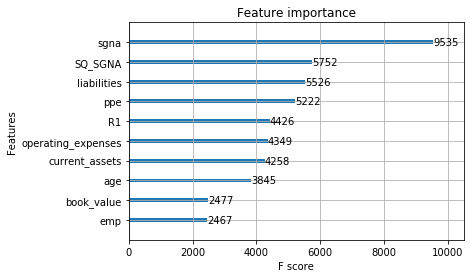

In [62]:
print("XGBoost Regression Results - Without Imputation")
xg=XGBoostReg(X_train,y_train,max_depth=50,objective ='reg:linear',n_estimators=400,learning_rate=0.1)
pred=RegPredict(xg,X_test,y_test)

xgb.plot_importance(xg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

XGBoost Regression Results - With Imputation
Mean Absolute Error: 6.1148795140723236
Mean Squared Error: 7622.375190112805
Root Mean Squared Error: 87.30621507151027
R-squared: 0.4046201862289829


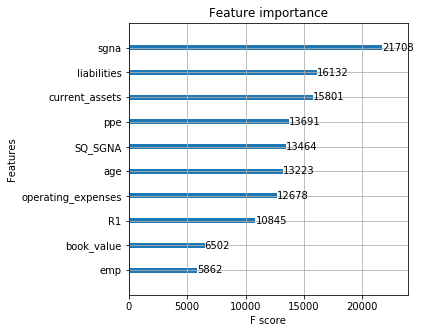

In [63]:
print("XGBoost Regression Results - With Imputation")
xg=XGBoostReg(X_train_imp,y_train_imp,max_depth=50,objective ='reg:linear',n_estimators=400,learning_rate=0.1)
pred=RegPredict(xg,X_test_imp,y_test_imp)

xgb.plot_importance(xg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

### AdaBoosting

In [64]:
print("AdaBoosting Results--Without Imputation")
adb=AdaBoost(X_train,y_train,n_estimators=100,learning_rate=1)
pred=RegPredict(adb,X_test,y_test)

AdaBoosting Results--Without Imputation
Mean Absolute Error: 1.3997120183858947
Mean Squared Error: 55.79975032222143
Root Mean Squared Error: 7.469923046606399
R-squared: 0.03628789061622928


C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [65]:
print("AdaBoosting Results--With Imputation")
adb=AdaBoost(X_train_imp,y_train_imp,n_estimators=100,learning_rate=1)
pred=RegPredict(adb,X_test_imp,y_test_imp)

AdaBoosting Results--With Imputation


C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error: 8.138004891948011
Mean Squared Error: 7850.198410666492
Root Mean Squared Error: 88.60134542243979
R-squared: 0.386825031406125


### Decision Tree Regression

In [66]:
print("Decision Tree Results --Without Imputation")
dt=DecisionTreeReg(X_train,y_train,max_depth=100)
pred=RegPredict(dt,X_test,y_test)

print("---------------------------------------")
dt=DecisionTreeReg(X_train,y_train,max_depth=200)
pred=RegPredict(dt,X_test,y_test)

Decision Tree Results --Without Imputation
Mean Absolute Error: 1.12293729268889
Mean Squared Error: 55.98798684936348
Root Mean Squared Error: 7.482512068106772
R-squared: 0.03303687569971803
---------------------------------------
Mean Absolute Error: 1.0781428164172815
Mean Squared Error: 55.526012966515275
Root Mean Squared Error: 7.451577884348742
R-squared: 0.041015582101609493


In [67]:
print("Decision Tree Results --With Imputation")
dt=DecisionTreeReg(X_train_imp,y_train_imp,max_depth=100)
pred=RegPredict(dt,X_test_imp,y_test_imp)

print("---------------------------------------")
dt=DecisionTreeReg(X_train_imp,y_train_imp,max_depth=200)
pred=RegPredict(dt,X_test_imp,y_test_imp)

Decision Tree Results --With Imputation
Mean Absolute Error: 4.71960924368717
Mean Squared Error: 7168.959083777784
Root Mean Squared Error: 84.66970582078211
R-squared: 0.44003628557039154
---------------------------------------
Mean Absolute Error: 4.726443465098372
Mean Squared Error: 7166.929834306594
Root Mean Squared Error: 84.65772164608846
R-squared: 0.4401947892050354


### Orthogonal Matching Pursuit

In [68]:
print("Orthogonal Matching Pursuit Results--Without Imputation")
omp=OrthogonalMatchReg(X_train,y_train)
pred=RegPredict(omp,X_test,y_test)

Orthogonal Matching Pursuit Results--Without Imputation
Mean Absolute Error: 1.4218469350578549
Mean Squared Error: 56.493349216924805
Root Mean Squared Error: 7.516205772657159
R-squared: 0.024308810960479432


In [69]:
print("Orthogonal Matching Pursuit Results--With Imputation")
omp=OrthogonalMatchReg(X_train_imp,y_train_imp)
pred=RegPredict(omp,X_test_imp,y_test_imp)

Orthogonal Matching Pursuit Results--With Imputation
Mean Absolute Error: 14.226404206777046
Mean Squared Error: 12793.186050601429
Root Mean Squared Error: 113.10696729468715
R-squared: 0.0007308039330020666


### Bayesian Ridge Regression

In [70]:
print("Bayesian Ridge Regression Results--Without Imputation")
br=BayesianRidgeReg(X_train,y_train)
pred=RegPredict(br,X_test,y_test)

Bayesian Ridge Regression Results--Without Imputation
Mean Absolute Error: 1.365084502935324
Mean Squared Error: 51.84556558346588
Root Mean Squared Error: 7.200386488478648
R-squared: 0.1045802341029648


C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [71]:
print("Bayesian Ridge Regression Results--With Imputation")
br=BayesianRidgeReg(X_train_imp,y_train_imp)
pred=RegPredict(br,X_test_imp,y_test_imp)

Bayesian Ridge Regression Results--With Imputation
Mean Absolute Error: 13.902121333189038
Mean Squared Error: 12796.164919197245
Root Mean Squared Error: 113.12013489736142
R-squared: 0.0004981260359436801


C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Robust Linear Model Estimation using RANSAC

In [72]:
print("RANSAC Regression Results--Without Imputation")
ran=RansacReg(X_train,y_train)
pred=RegPredict(ran,X_test,y_test)

RANSAC Regression Results--Without Imputation
Mean Absolute Error: 1.705052260756193
Mean Squared Error: 58.92134867504873
Root Mean Squared Error: 7.676024275303507
R-squared: -0.01762493365055051


In [73]:
print("RANSAC Regression Results--With Imputation")
ran=RansacReg(X_train_imp,y_train_imp)
pred=RegPredict(ran,X_test_imp,y_test_imp)

RANSAC Regression Results--With Imputation
Mean Absolute Error: 130.39035165913796
Mean Squared Error: 448352.4963882772
Root Mean Squared Error: 669.5912905558713
R-squared: -34.02058336746248


### RandomForest Regression

In [74]:
print("RandomForest Regression Results--Without Imputation")
rf=RandomForestReg(X_train,y_train,n_estimators = 1000, random_state = 42)
pred=RegPredict(rf,X_test,y_test)
print("-----------------------------------------")
rf=RandomForestReg(X_train,y_train,n_estimators = 500, random_state = 42)
pred=RegPredict(rf,X_test,y_test)

RandomForest Regression Results--Without Imputation


C:\Users\nisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Mean Absolute Error: 0.981809554922663
Mean Squared Error: 54.84813491064189
Root Mean Squared Error: 7.405952667323893
R-squared: 0.052723148665228314
-----------------------------------------


C:\Users\nisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Mean Absolute Error: 0.980083793237662
Mean Squared Error: 54.88957898034099
Root Mean Squared Error: 7.40875016317469
R-squared: 0.05200737213216966


In [75]:
print("RandomForest Regression Results--With Imputation")
rf=RandomForestReg(X_train_imp,y_train_imp,n_estimators = 1000, random_state = 42)
pred=RegPredict(rf,X_test_imp,y_test_imp)
print("-----------------------------------------")
rf=RandomForestReg(X_train_imp,y_train_imp,n_estimators = 500, random_state = 42)
pred=RegPredict(rf,X_test_imp,y_test_imp)

RandomForest Regression Results--With Imputation


C:\Users\nisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Mean Absolute Error: 6.962282813741998
Mean Squared Error: 8216.802519336221
Root Mean Squared Error: 90.64658029587338
R-squared: 0.3581897726444472
-----------------------------------------


C:\Users\nisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Mean Absolute Error: 7.043573785659771
Mean Squared Error: 8293.660307802564
Root Mean Squared Error: 91.06953556377985
R-squared: 0.35218645023605943


### Gradient Boosting Regression

In [76]:
print("Gradient Boosting Regression Results--Without Imputation")
gb=GradientBoostReg(X_train,y_train,n_estimators=1000,max_depth=30,learning_rate=1,criterion='mse')
pred=RegPredict(gb,X_test,y_test)
print("------------------------------------------")
gb=GradientBoostReg(X_train,y_train,n_estimators=500,max_depth=50,learning_rate=1,criterion='mse')
pred=RegPredict(gb,X_test,y_test)

Gradient Boosting Regression Results--Without Imputation
Mean Absolute Error: 1.096889617401853
Mean Squared Error: 55.94156015150328
Root Mean Squared Error: 7.479409077694793
R-squared: 0.03383870672348088
------------------------------------------


C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error: 1.1090552710433992
Mean Squared Error: 56.029568834398006
Root Mean Squared Error: 7.485290163674218
R-squared: 0.03231871724419488


In [77]:
print("Gradient Boosting Regression Results--With Imputation")
gb=GradientBoostReg(X_train_imp,y_train_imp,n_estimators=1000,max_depth=30,learning_rate=1,criterion='mse')
pred=RegPredict(gb,X_test_imp,y_test_imp)
print("------------------------------------------")
gb=GradientBoostReg(X_train_imp,y_train_imp,n_estimators=500,max_depth=50,learning_rate=1,criterion='mse')
pred=RegPredict(gb,X_test_imp,y_test_imp)

Gradient Boosting Regression Results--With Imputation


C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Absolute Error: 4.45822438196421
Mean Squared Error: 7148.578667419664
Root Mean Squared Error: 84.5492676929828
R-squared: 0.44162818943148896
------------------------------------------
Mean Absolute Error: 4.824407455195024
Mean Squared Error: 8202.053855027221
Root Mean Squared Error: 90.56519118859752
R-squared: 0.35934178324359145


C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Stepwise Regression

In [78]:
result = stepwise_selection(X_train, y_train)
print('Resulting features from Stepwise Selection without Imputation:')
print(result) 

C:\Users\nisha\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\nisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Add  emp                            with p-value 2.83788e-10
Add  sgna                           with p-value 6.3252e-18
Add  ppe                            with p-value 9.95731e-20
Add  liabilities                    with p-value 5.01377e-11
Add  age                            with p-value 3.81748e-05
Add  R1                             with p-value 0.00318298
Resulting features from Stepwise Selection without Imputation:
['emp', 'sgna', 'ppe', 'liabilities', 'age', 'R1']


In [79]:
result = stepwise_selection(X_train_imp, y_train_imp)
print('Resulting features from Stepwise Selection with Imputation:')
print(result) 

Resulting features from Stepwise Selection with Imputation:
[]


### Studying the individual effect of Control variables on Model 2

#### Data with missing values removed

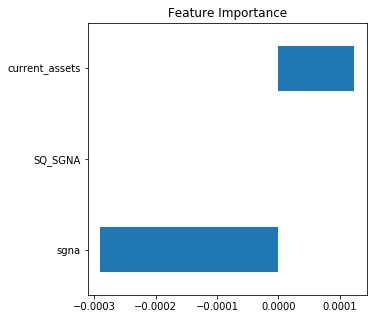

Ridge Regression metrcis for Control variables- current_assets
Mean Absolute Error: 1.3974872523672854
Mean Squared Error: 57.54803085508371
Root Mean Squared Error: 7.5860418437472195
R-squared: 0.006093506046584873
----------------------------------------------------------------------


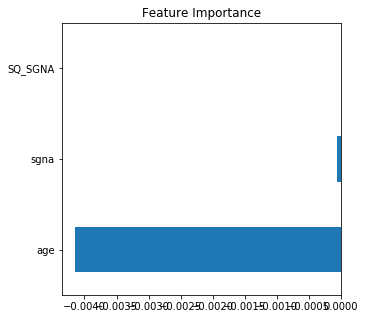

Ridge Regression metrcis for Control variables- age
Mean Absolute Error: 1.3560014647207501
Mean Squared Error: 57.90528508144042
Root Mean Squared Error: 7.609552226080088
R-squared: -7.659726176956205e-05
----------------------------------------------------------------------


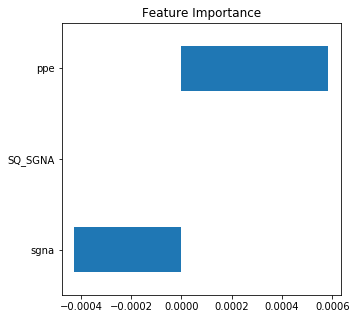

Ridge Regression metrcis for Control variables- ppe
Mean Absolute Error: 1.39356552725618
Mean Squared Error: 53.69890882339742
Root Mean Squared Error: 7.327953931582637
R-squared: 0.07257132164632085
----------------------------------------------------------------------


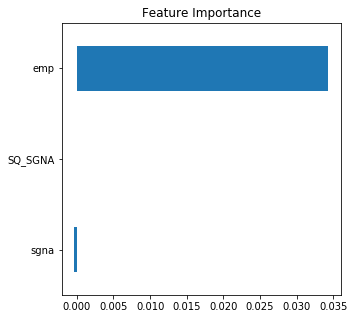

Ridge Regression metrcis for Control variables- emp
Mean Absolute Error: 1.4885425982448262
Mean Squared Error: 54.03734401886206
Root Mean Squared Error: 7.351009727844336
R-squared: 0.0667262400065729
----------------------------------------------------------------------


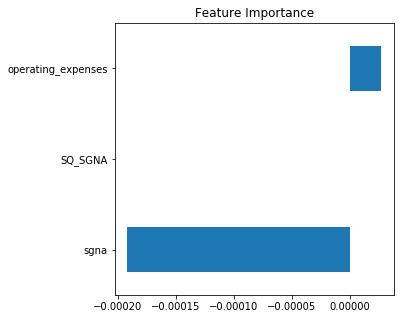

Ridge Regression metrcis for Control variables- operating_expenses
Mean Absolute Error: 1.3948357530285986
Mean Squared Error: 57.67530847551063
Root Mean Squared Error: 7.594426145240378
R-squared: 0.0038953065322381297
----------------------------------------------------------------------


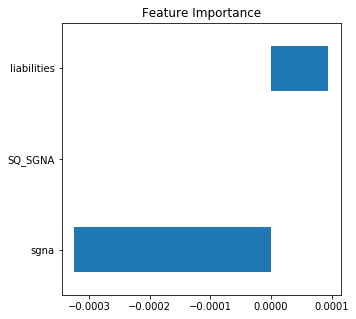

Ridge Regression metrcis for Control variables- liabilities
Mean Absolute Error: 1.3850689928031756
Mean Squared Error: 56.767296028192945
Root Mean Squared Error: 7.534407476915019
R-squared: 0.019577501988277013
----------------------------------------------------------------------


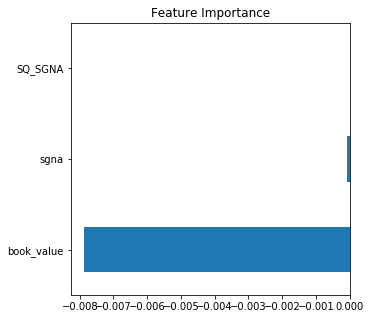

Ridge Regression metrcis for Control variables- book_value
Mean Absolute Error: 1.349285607969642
Mean Squared Error: 57.92296019570027
Root Mean Squared Error: 7.610713514231124
R-squared: -0.00038186245648108574
----------------------------------------------------------------------


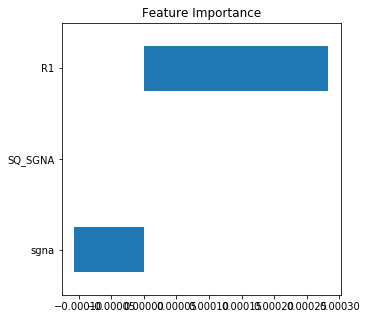

Ridge Regression metrcis for Control variables- R1
Mean Absolute Error: 1.35773154159907
Mean Squared Error: 57.82313797887251
Root Mean Squared Error: 7.604152679876471
R-squared: 0.001342157428678603
----------------------------------------------------------------------


In [80]:
for i in range(len(CV)):
    X = df[IV+[CV[i]]]
    y = df['growth_in_profit'].values.reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    ridge=RidgeReg(X_train,y_train)
    
    #Plotting Feature Importances after adding CV individually
    feature_list = list(X.columns)
    plot_feature_imp(ridge,index=feature_list)
    
    print('Ridge Regression metrcis for Control variables-',CV[i])
    pred=RegPredict(ridge,X_test,y_test)
    print("----------------------------------------------------------------------")

#### Imputed Data

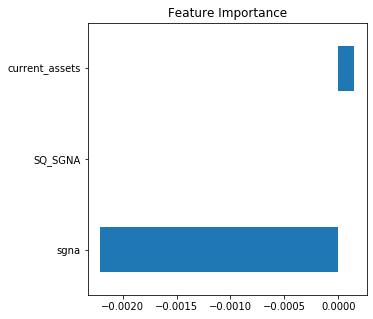

Ridge Regression metrcis for Control variables- current_assets
Mean Absolute Error: 14.229619986573656
Mean Squared Error: 12795.401407180962
Root Mean Squared Error: 113.11676006313547
R-squared: 0.0005577635676485837
----------------------------------------------------------------------


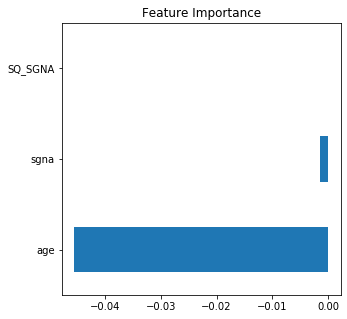

Ridge Regression metrcis for Control variables- age
Mean Absolute Error: 14.361662019749621
Mean Squared Error: 12782.766283693865
Root Mean Squared Error: 113.06089635101017
R-squared: 0.0015446865780087693
----------------------------------------------------------------------


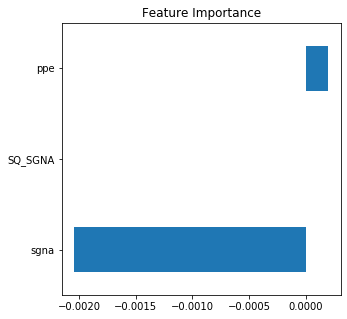

Ridge Regression metrcis for Control variables- ppe
Mean Absolute Error: 14.177360924912898
Mean Squared Error: 12795.957428827618
Root Mean Squared Error: 113.11921776969473
R-squared: 0.0005143330022168158
----------------------------------------------------------------------


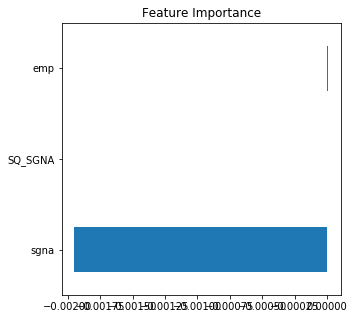

Ridge Regression metrcis for Control variables- emp
Mean Absolute Error: 14.254190703814764
Mean Squared Error: 12795.711125358615
Root Mean Squared Error: 113.11812907469172
R-squared: 0.0005335716397607548
----------------------------------------------------------------------


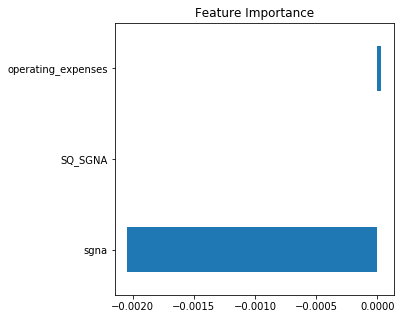

Ridge Regression metrcis for Control variables- operating_expenses
Mean Absolute Error: 14.226300153621105
Mean Squared Error: 12795.538837261496
Root Mean Squared Error: 113.1173675315223
R-squared: 0.0005470289745965751
----------------------------------------------------------------------


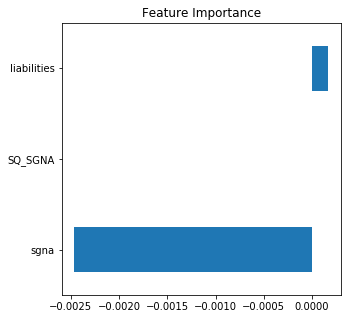

Ridge Regression metrcis for Control variables- liabilities
Mean Absolute Error: 14.191710323740542
Mean Squared Error: 12784.131840200667
Root Mean Squared Error: 113.06693522069423
R-squared: 0.0014380236601602148
----------------------------------------------------------------------


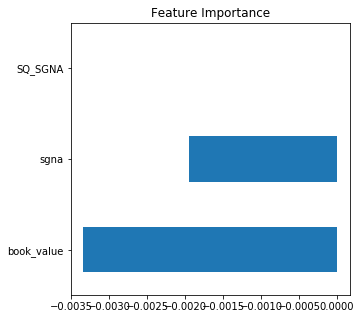

Ridge Regression metrcis for Control variables- book_value
Mean Absolute Error: 14.261893879635467
Mean Squared Error: 12794.694989957554
Root Mean Squared Error: 113.11363750652507
R-squared: 0.0006129414543869505
----------------------------------------------------------------------


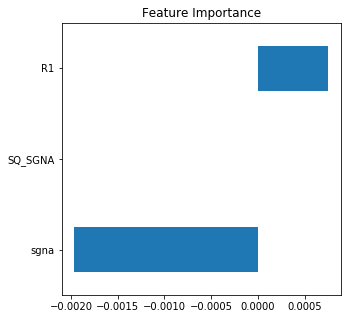

Ridge Regression metrcis for Control variables- R1
Mean Absolute Error: 14.237171308168348
Mean Squared Error: 12795.553871821307
Root Mean Squared Error: 113.11743398707958
R-squared: 0.0005458546328465097
----------------------------------------------------------------------


In [81]:
for i in range(len(CV)):
    X = df_imp[IV+[CV[i]]]
    y = df_imp['growth_in_profit'].values.reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    ridge=RidgeReg(X_train,y_train)
    
    #Plotting Feature Importances after adding CV individually
    feature_list = list(X.columns)
    plot_feature_imp(ridge,index=feature_list)
    
    print('Ridge Regression metrcis for Control variables-',CV[i])
    pred=RegPredict(ridge,X_test,y_test)
    print("----------------------------------------------------------------------")

### Studying the effect of Control Variables which have positive Feature Importances when added individually

#### Adding current_assets, ppe, emp, operating_expenses, liabilities, R1

#### Data with no missing values

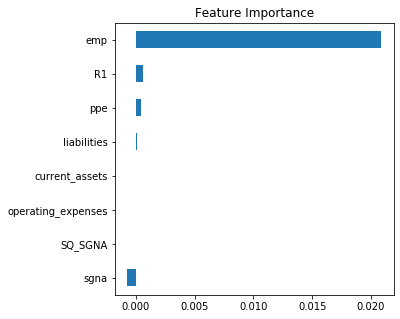

Mean Absolute Error: 1.4088783583143214
Mean Squared Error: 51.65139220399184
Root Mean Squared Error: 7.186890301374569
R-squared: 0.10793378382385976


In [82]:
X = df[['sgna','SQ_SGNA','current_assets','ppe','emp','operating_expenses','liabilities','R1']]
y = df[DV].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ridge=RidgeReg(X_train,y_train)
#Plotting Feature Importances after adding CV individually
feature_list = list(X.columns)
plot_feature_imp(ridge,index=feature_list)
pred=RegPredict(ridge,X_test,y_test)

#### Imputed Data

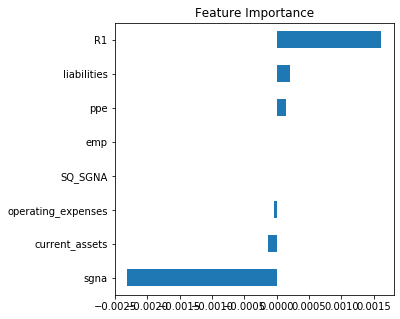

Mean Absolute Error: 14.16339456975888
Mean Squared Error: 12781.880675019593
Root Mean Squared Error: 113.05697977135065
R-squared: 0.0016138610170007839


In [83]:
X = df_imp[['sgna','SQ_SGNA','current_assets','ppe','emp','operating_expenses','liabilities','R1']]
y = df_imp[DV].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ridge=RidgeReg(X_train,y_train)
#Plotting Feature Importances after adding CV individually
feature_list = list(X.columns)
plot_feature_imp(ridge,index=feature_list)
pred=RegPredict(ridge,X_test,y_test)

### Studying the effect of Control Variables which have negative Feature Importances when added individually

#### Adding book_value,age

#### Data with no missing Values

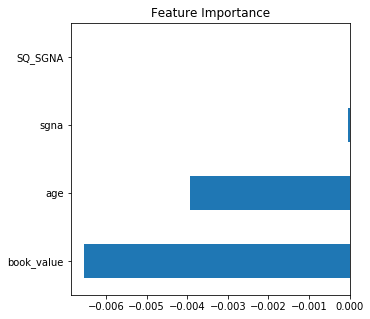

Mean Absolute Error: 1.3563176627460125
Mean Squared Error: 57.914894627735165
Root Mean Squared Error: 7.610183613273412
R-squared: -0.00024256280958034893


In [84]:
X = df[['sgna','SQ_SGNA','age','book_value']]
y = df[DV].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ridge=RidgeReg(X_train,y_train)
#Plotting Feature Importances after adding CV individually
feature_list = list(X.columns)
plot_feature_imp(ridge,index=feature_list)
pred=RegPredict(ridge,X_test,y_test)

#### Imputed Data

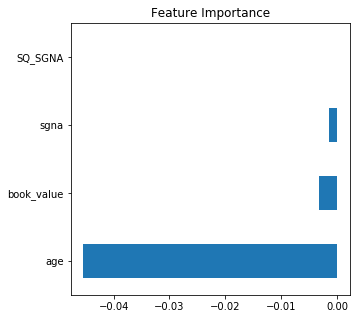

Mean Absolute Error: 14.371259272508109
Mean Squared Error: 12781.765641200223
Root Mean Squared Error: 113.0564710275366
R-squared: 0.0016228462495884166


In [85]:
X = df_imp[['sgna','SQ_SGNA','age','book_value']]
y = df_imp[DV].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ridge=RidgeReg(X_train,y_train)
#Plotting Feature Importances after adding CV individually
feature_list = list(X.columns)
plot_feature_imp(ridge,index=feature_list)
pred=RegPredict(ridge,X_test,y_test)